<a href="https://colab.research.google.com/github/meka-williams/Capstone-Finance-AI-Project/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA Modeling of Stock Prices (with Alpha Vantage API)

Traditional ML on Finanial Time Series focusing on the hull moving average and the directional moving index (ADX).


###By: The Lost Boy: Shameka Williams, Salma Omran, Spencer Haber, Payal Moorti, Miracle Sanchez



### 1. Import all of the necessary libraries and connect to the API.

In [ ]:
#imports

import requests
from google.colab import userdata
import os, json
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
!pip install ta

In [ ]:
#API setup

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "GPOTJ4638HWF4A6H")
BASE_URL = "https://www.alphavantage.co/query"

###2. Create our helper functions
- fetch_json -- takes in a param dictionary, retries amount, and how many seconds to wait between retries. It then sends a request the API and returns a json once valid 'Time Series' data is detected.
- fetch_intraday -- takes in a stock symbol, and calls the fetch_json function for the information on the specified stock with a specified interval (5 minutes). Then, the function formats the json payload into a pandas data frame containing the price data, returns that, and saves it as a CSV

In [ ]:
#initial data fetch

def _fetch_json(params, retries=3, sleep_s=15):

    for i in range(retries):
        r = requests.get(BASE_URL, params=params, timeout=30)
        r.raise_for_status()
        payload = r.json()

        #return if valid data was retrieved
        if any("Time Series" in k for k in payload.keys()):
            return payload

        #API limit error
        if "Note" in payload and i < retries - 1:
            print("The API limit has been hit, retrying")
            time.sleep(sleep_s)
            continue

        #payload for debugging
        return payload


In [ ]:
#time series fetch - 5 minute interval used to show volatility


def fetch_intraday(symbol: str, interval: str = "5min", outputsize: str = "compact") -> pd.DataFrame:
    """
    Returns DataFrame indexed by datetime with numeric columns.
    """

    params = {
        "function": "TIME_SERIES_INTRADAY",
        "symbol": symbol,
        "interval": interval,
        "outputsize": outputsize,
        "apikey": API_KEY,
    }

    #data fetch
    payload = _fetch_json(params)
    key = next((k for k in payload.keys() if "Time Series" in k), None)
    if not key:
        raise ValueError(f"Unexpected API response for {symbol}: {payload}")

    df = pd.DataFrame(payload[key]).T
    df.index = pd.to_datetime(df.index)
    df = df.rename(columns=lambda c: c.split(". ", 1)[-1])  # "1. open" -> "open"
    df = df.apply(pd.to_numeric, errors="coerce").sort_index()

    #save data to CSV
    out_path = DATA_DIR / f"{symbol}_{interval}_intraday.csv"
    df.to_csv(out_path)
    print(f"Downloaded {symbol} ({interval}): {len(df)} rows → {out_path}")
    print(f"Date range: {df.index.min()} → {df.index.max()}")

    return df


###3. Test the helper functions to validate data extraction
This code block calls both of the heloer functions to retrieve and format stock price data for the stock inputted by the user.

- In this case, we use a 5 minute interval for a one month period which means that for each day in that month, we can see one 5 minute piece of the trading price.

Enter a stock symbol (e.g., IBM, AAPL, MSFT): NKE
Downloaded NKE (5min): 4212 rows → data/NKE_5min_intraday.csv
Date range: 2025-09-18 04:00:00 → 2025-10-17 19:55:00

--- Sample of the extracted data ---
                      open   high    low  close  volume
2025-09-18 04:00:00  73.21  73.60  73.21  73.54    5738
2025-09-18 04:05:00  73.54  73.54  73.50  73.50     321
2025-09-18 04:10:00  73.50  73.52  73.45  73.52     581
2025-09-18 04:15:00  73.51  73.73  73.51  73.68    2017
2025-09-18 04:20:00  73.64  73.68  73.60  73.62   11289

--- Data summary ---
              open         high          low        close        volume
count  4212.000000  4212.000000  4212.000000  4212.000000  4.212000e+03
mean     70.039664    70.130741    69.945741    70.042251  1.385467e+05
std       2.364220     2.390177     2.375583     2.368940  5.894711e+05
min      63.550000    63.780000    59.733700    63.550000  1.000000e+00
25%      68.443250    68.530000    68.310900    68.437500  5.037500e+02
50%   

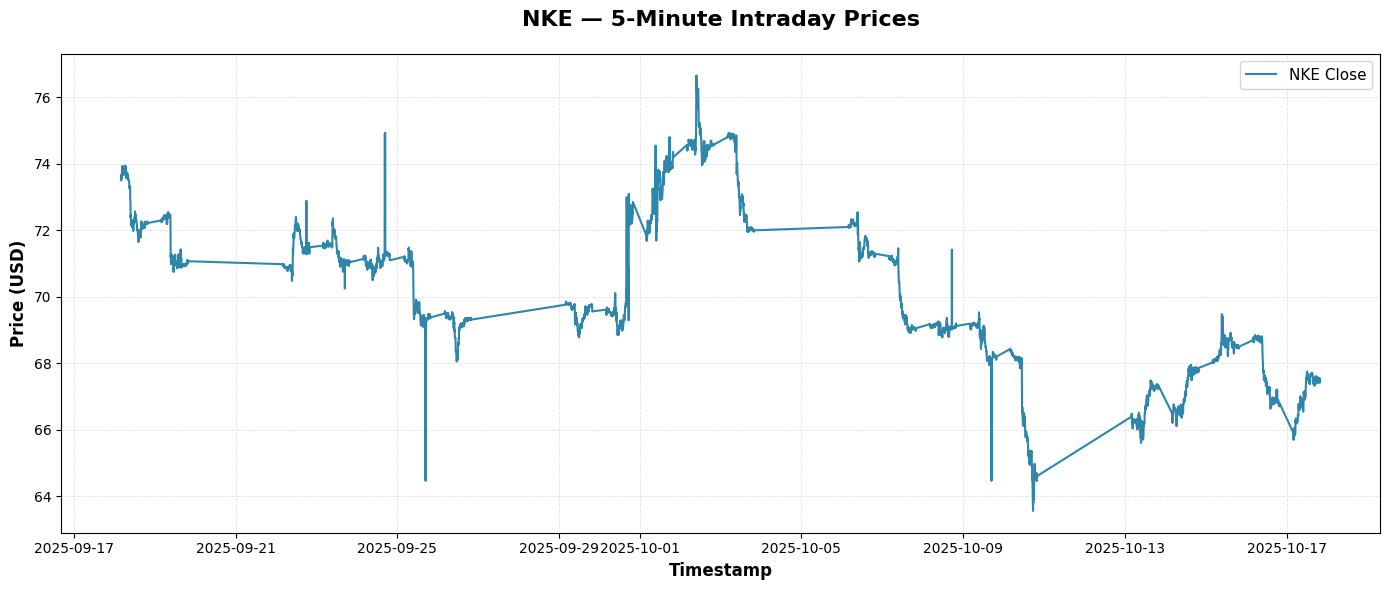

In [ ]:
#initial test to validate data extraction

symbol = input("Enter a stock symbol (e.g., IBM, AAPL, MSFT): ").upper()
df = fetch_intraday(symbol, interval="5min", outputsize="full")

#show first 5 rows
print("\n--- Sample of the extracted data ---")
print(df.head())
print("\n--- Data summary ---")
print(df.describe())


#vis
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["close"], label=f"{symbol} Close", color="#2E86AB", linewidth=1.5)
plt.title(f"{symbol} — 5-Minute Intraday Prices", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
plt.ylabel("Price (USD)", fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()


### 4. Exploratory Data Analysis -- Get to know your data
Once we are done obtaining and formatting the data, we can begin visually understanding it by looking at it's averages, trends, and votality.

1. We use rolling stats to smooth the data and clearly see if any votality or trend is present.
- Moving Average -- Instead of looking at the daily stock prices that can fluctuate heavily, the charts show the average price over the last 20 days instead. This then makes it easier to see the big picture -- on average, does the price go up or down?
- Rolling Standard Deviation -- If the rolling standard deviation is low, that means the price stays pretty steady and vice versa.
2. Next, we measure the daily returns -- how much the price changes from one 5 min interval to the next -- in percentage terms.
3. Then, we combine the 5 minute intervals to determine how many shares were traded for a stock during that one day.

=== Summary statistics ===
           open      high       low     close        volume
count  4212.000  4212.000  4212.000  4212.000  4.212000e+03
mean     70.040    70.131    69.946    70.042  1.385467e+05
std       2.364     2.390     2.376     2.369  5.894711e+05
min      63.550    63.780    59.734    63.550  1.000000e+00
25%      68.443    68.530    68.311    68.438  5.037500e+02
50%      69.590    69.663    69.520    69.590  6.005000e+03
75%      71.620    71.759    71.540    71.621  1.179242e+05
max      76.640    82.700    76.450    76.660  2.084903e+07


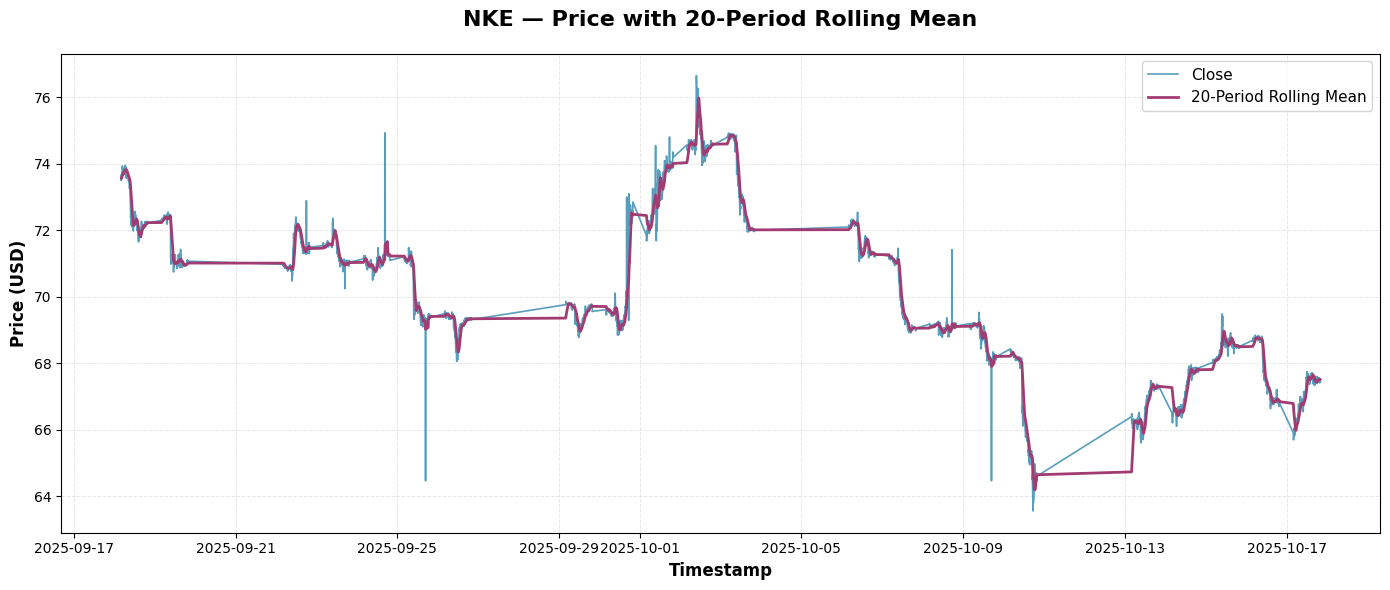

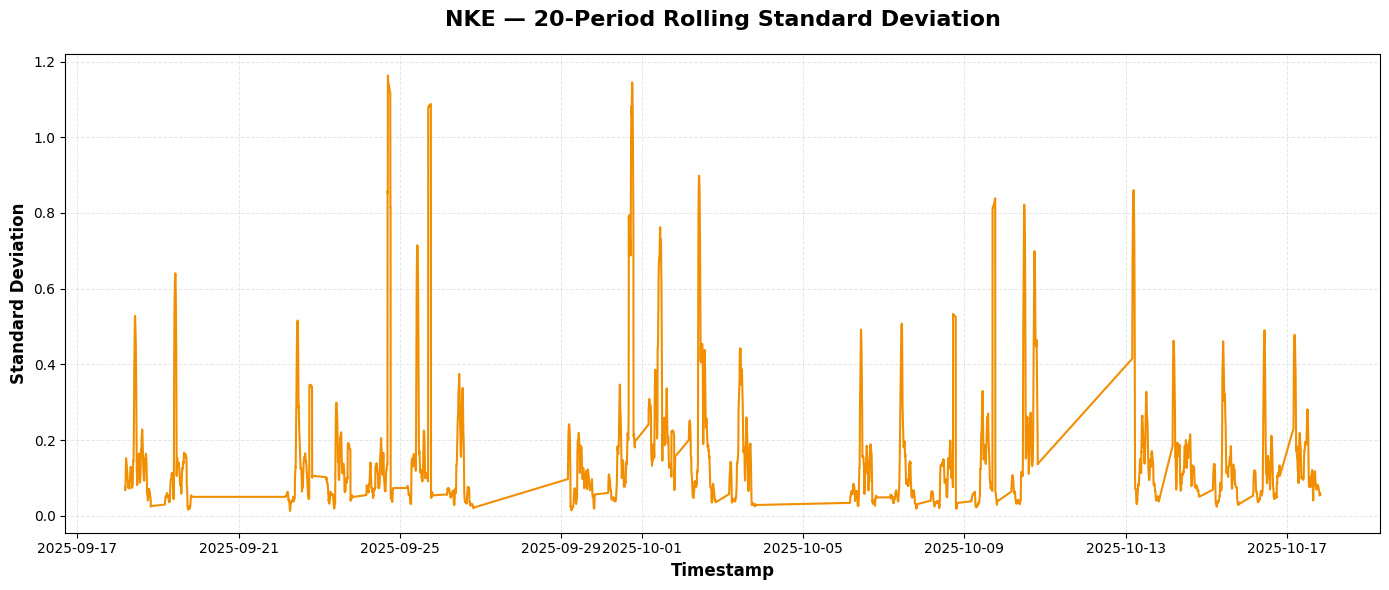

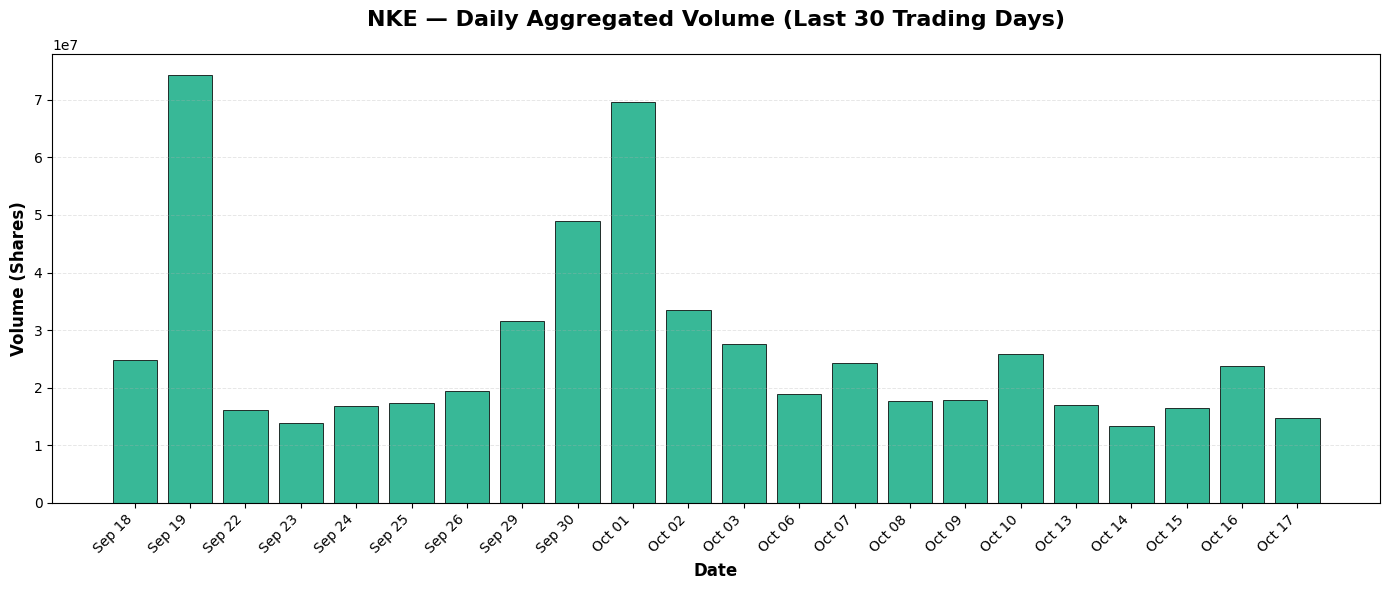

In [ ]:
#exploratory visuals (line plot, rolling stats) + summary stats

price_col = "adjusted_close" if "adjusted_close" in df.columns else "close"

#rolling stats
rolling_window = 20
df["roll_mean_20"] = df[price_col].rolling(rolling_window, min_periods=5).mean()
df["roll_std_20"] = df[price_col].rolling(rolling_window, min_periods=5).std()

#daily returns
df["return_1d"] = df[price_col].pct_change()

#summary stats
summary = df[["open","high","low",price_col,"volume"]].describe().round(3)
print("=== Summary statistics ===")
print(summary)

#save summary csv
DATA_DIR = Path("data")
summary.to_csv(DATA_DIR / f"{symbol}_summary_stats.csv")

#price with rolling mean
plt.figure(figsize=(14, 6))
plt.plot(df.index, df[price_col], label=price_col.replace('_', ' ').title(),
         color="#2E86AB", linewidth=1.2, alpha=0.8)
plt.plot(df.index, df["roll_mean_20"], label=f"{rolling_window}-Period Rolling Mean",
         color="#A23B72", linewidth=2)
plt.title(f"{symbol} — Price with {rolling_window}-Period Rolling Mean",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
plt.ylabel("Price (USD)", fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

#rolling volatility proxy (std dev)
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["roll_std_20"], color="#F18F01", linewidth=1.5)
plt.title(f"{symbol} — {rolling_window}-Period Rolling Standard Deviation",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
plt.ylabel("Standard Deviation", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

#volume by day
df["date"] = df.index.date
daily_volume = df.groupby("date")["volume"].sum()

#last 30 trading days
daily_volume_last = daily_volume[-30:]
plt.figure(figsize=(14, 6))
positions = range(len(daily_volume_last))
plt.bar(positions, daily_volume_last.values, color="#06A77D", alpha=0.8, edgecolor='black', linewidth=0.7)
plt.xticks(positions, [d.strftime("%b %d") for d in daily_volume_last.index], rotation=45, ha='right')
plt.title(f"{symbol} — Daily Aggregated Volume (Last 30 Trading Days)",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Date", fontsize=12, fontweight='bold')
plt.ylabel("Volume (Shares)", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7, axis='y')
plt.tight_layout()
plt.show()

### 5. Prepare data for Analysis
1. Ensure that the data is in chronological order.
2. Infer the frequency of our data (5 min intervals or daily) and set the window size for the rolling averages.
3. Print the raw time series to see any initial upward or downward trends. Also plot the data with the rolling mean. This is the first check for stationary or non-stationary data.

=== TIME SERIES CHARACTERISTICS REPORT ===



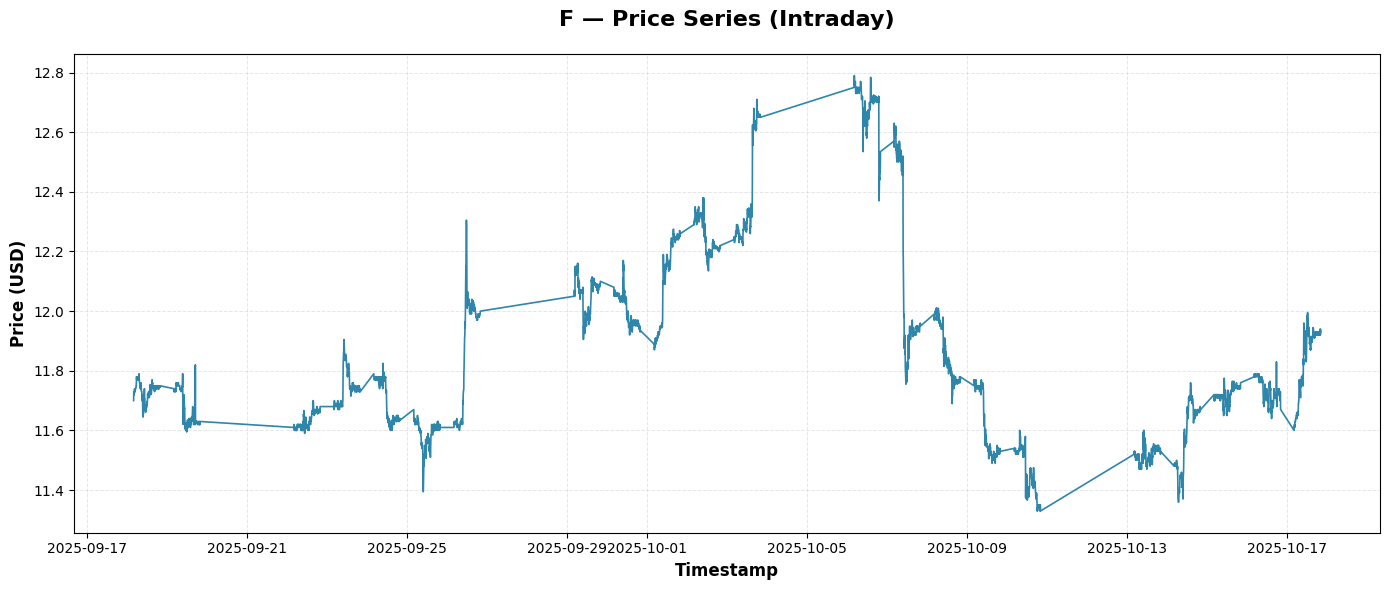

The raw price series shows an upward/downward drift and volatility clustering, suggesting it is likely non-stationary.


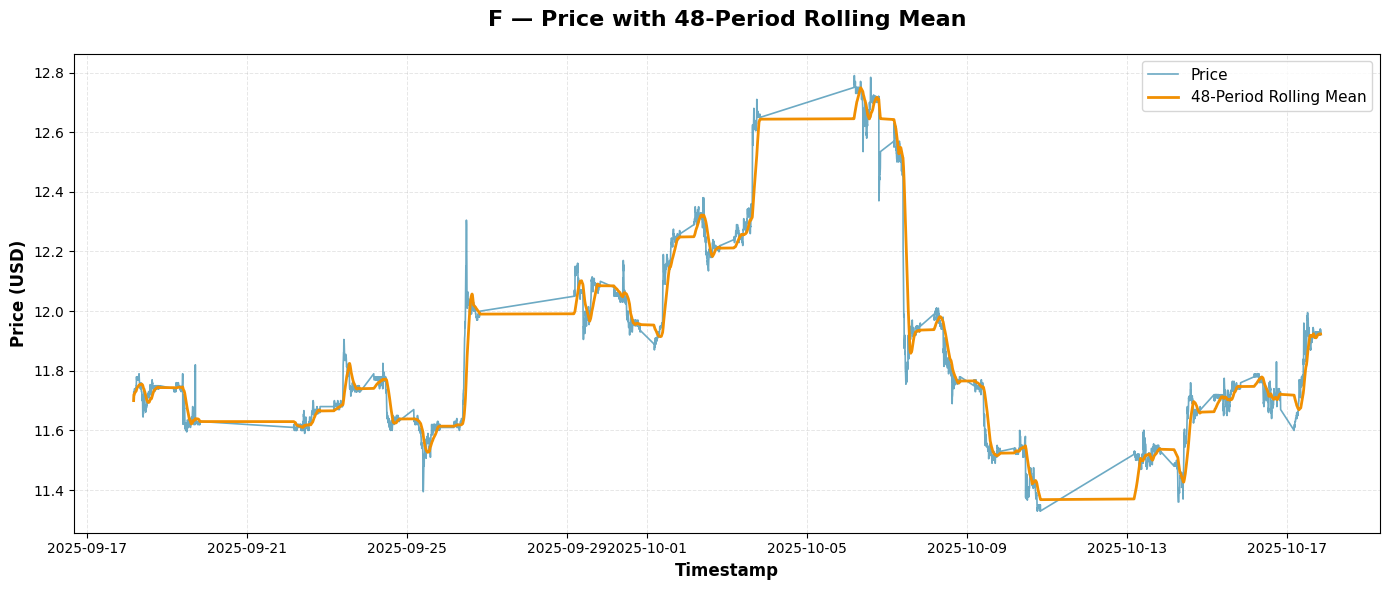

Rolling mean smooths out daily fluctuations, helping visualize the underlying trend.


In [ ]:
#prep & clean df for analysis

df = df.sort_index()

#dynamic column names
price_col = next((c for c in df.columns if "close" in c.lower()), "close")
returns_col = "return_1d"
if returns_col not in df:
    df[returns_col] = df[price_col].pct_change()

#frequency
inferred_freq = pd.infer_freq(df.index[:10])
period = 30 if inferred_freq and "D" in inferred_freq else 48
print("=== TIME SERIES CHARACTERISTICS REPORT ===\n")

#plot the raw series
plt.figure(figsize=(14, 6))
plt.plot(df.index, df[price_col], color="#2E86AB", linewidth=1.2)
plt.title(f"{symbol} — Price Series ({'Daily' if 'D' in str(inferred_freq) else 'Intraday'})",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
plt.ylabel("Price (USD)", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()
print("The raw price series shows an upward/downward drift and volatility clustering, "
      "suggesting it is likely non-stationary.")

#plot rolling stats
df["roll_mean"] = df[price_col].rolling(window=period, min_periods=1).mean()
plt.figure(figsize=(14, 6))
plt.plot(df.index, df[price_col], label="Price", alpha=0.7, color="#2E86AB", linewidth=1.2)
plt.plot(df.index, df["roll_mean"], label=f"{period}-Period Rolling Mean",
         color="#F18F01", linewidth=2)
plt.title(f"{symbol} — Price with {period}-Period Rolling Mean",
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
plt.ylabel("Price (USD)", fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()
print("Rolling mean smooths out daily fluctuations, helping visualize the underlying trend.")


### 6. Decomposition
1. Decomposition splits the time series into trend, seasonality, and residuals.
 - Trends include long-term analysis of the stock. Does it have an upward or downward trend? Or is it flat?
 - Seasonality includes any repetitiveness. Maybe a stock rises every day at 11am and dips every dat at 2pm.
 - Residuals are whatever is left over from the trends and seasonality. Also known as the noise.

 2. We use a multiplicative model where we multiply our findings for the three components of the time series. This model works for the stock data due to the level of votality.

 ### Autocorrelation / Partial Autocorrelation
 - Both tools are used to analyze how the current data is affected by the past (lagged) values.
 - These then determine the parameters for ARIMA.

 ### ADF
 - Checks if the time series is stationary or not.

In [ ]:
#decomposition - trend/seasonality/residuals
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df[price_col].dropna(), model="multiplicative", period=period)
fig = result.plot()
fig.set_size_inches(14, 10)
plt.suptitle(f"{symbol} — Trend, Seasonality, and Residuals", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
print("Decomposition separates the series into:\n"
      "- Trend: Long-term direction of the stock price.\n"
      "- Seasonality: Repeating short-term cycles (monthly/weekly effects).\n"
      "- Residuals: Irregular noise not explained by trend or seasonality.\n")

#ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(14, 5))
plot_acf(df['return_1d'].dropna(), lags=40, ax=ax, color="#2E86AB")
plt.title(f"{symbol} — Autocorrelation Function (ACF)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Lag", fontsize=12, fontweight='bold')
plt.ylabel("Autocorrelation", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(14, 5))
plot_pacf(df[returns_col].dropna(), lags=40, method="ywm", ax=ax, color="#A23B72")
plt.title(f"{symbol} — Partial Autocorrelation Function (PACF)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Lag", fontsize=12, fontweight='bold')
plt.ylabel("Partial Autocorrelation", fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()
print("ACF shows correlations with past lags; PACF isolates direct effects of lags. "
      "These help identify ARIMA model orders.")

#ADF Test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df[returns_col].dropna(), autolag='AIC')
print("\n=== Augmented Dickey-Fuller Test ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value : {adf_result[1]:.4f}")
print("Critical Values:", adf_result[4])
if adf_result[1] < 0.05:
    print("✓ The series is stationary. The null hypothesis is rejected.")
else:
    print("✗ The series is non-stationary. Fail to reject null hypothesis. Differencing needed.")

NameError: name 'period' is not defined

### 7. Differencing / Transformations
Differencing is used here to remove the trends in the time series in order for it to fluctuate around a constant mean. For example, a stock can still go up to 10 and down to 5 but it will always remain somewhere between those two values.


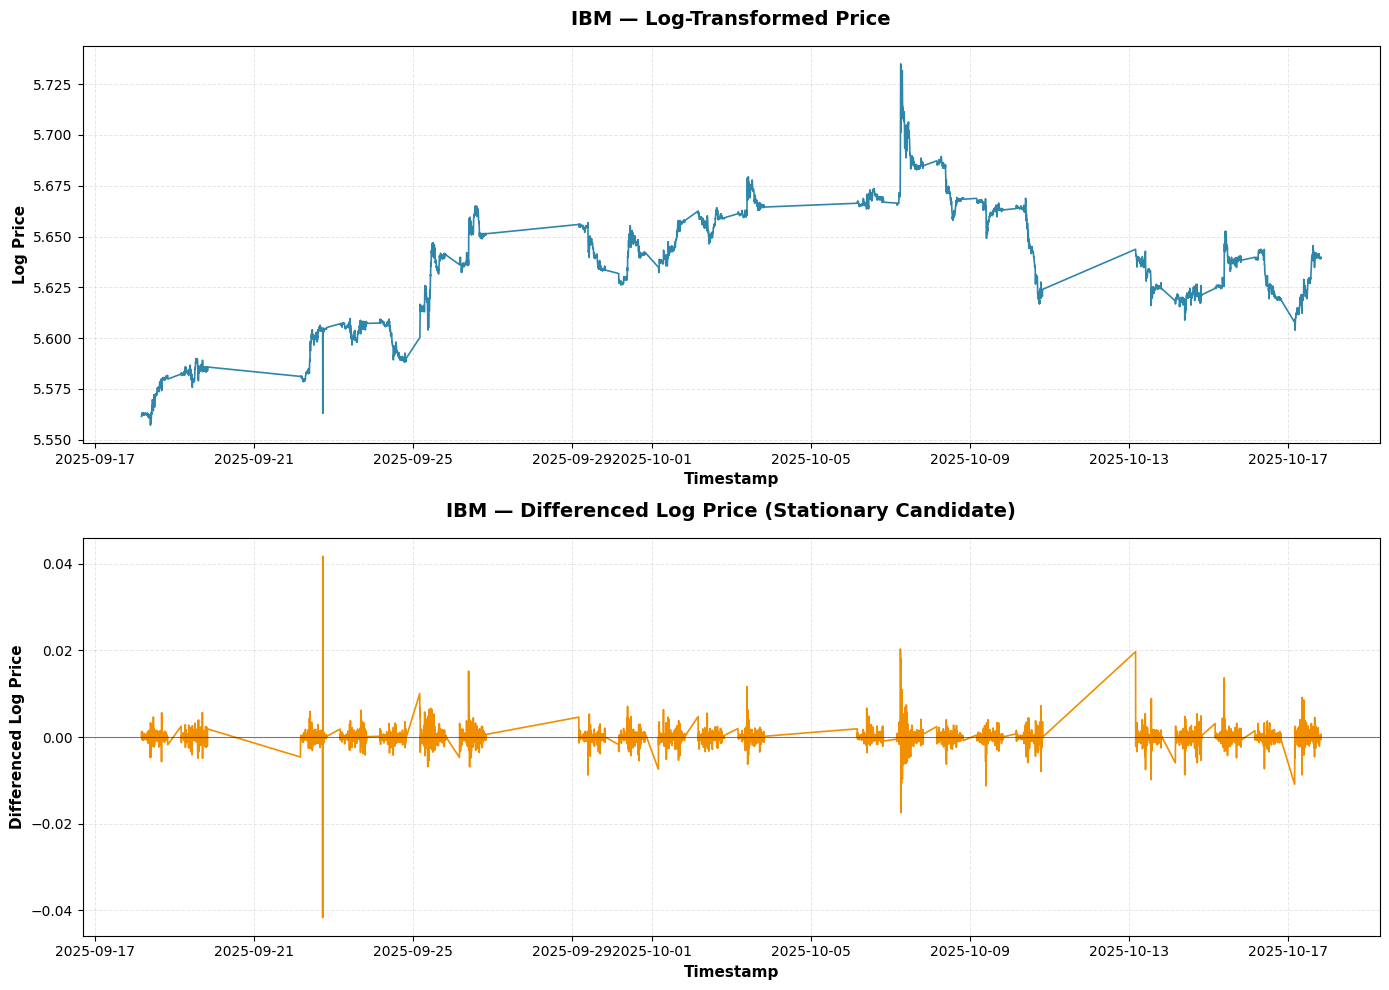


=== ADF on Differenced Log Price ===
ADF Statistic: -18.9113
p-value : 0.0000
Critical Values: {'1%': np.float64(-3.431913516254953), '5%': np.float64(-2.8622308755064814), '10%': np.float64(-2.5671377589502247)}
✓ The differenced series is stationary. Ready for ARIMA modeling.


In [ ]:
# Apply Differencing / Transformations

# Log-transform (helps stabilize variance)
df["log_price"] = np.log(df[price_col])
# First difference of log price (approx daily returns)
df["diff_log_price"] = df["log_price"].diff()
# Drop NaNs
stationary_series = df["diff_log_price"].dropna()

#before vs after differencing
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

#log-transformed price
axes[0].plot(df.index, df["log_price"], color="#2E86AB", linewidth=1.2)
axes[0].set_title(f"{symbol} — Log-Transformed Price", fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel("Timestamp", fontsize=11, fontweight='bold')
axes[0].set_ylabel("Log Price", fontsize=11, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--', linewidth=0.7)

#differenced log price
axes[1].plot(stationary_series.index, stationary_series, color="#F18F01", linewidth=1.2)
axes[1].set_title(f"{symbol} — Differenced Log Price (Stationary Candidate)", fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel("Timestamp", fontsize=11, fontweight='bold')
axes[1].set_ylabel("Differenced Log Price", fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()

#re-run ADF test
adf_result = adfuller(stationary_series, autolag="AIC")
print("\n=== ADF on Differenced Log Price ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value : {adf_result[1]:.4f}")
print("Critical Values:", adf_result[4])
if adf_result[1] < 0.05:
    print("✓ The differenced series is stationary. Ready for ARIMA modeling.")
else:
    print("✗ The series may need additional differencing.")

### 8. AR, MA, and ARIMA Models
Autoagressive Model -- this model predicts future values based on changes in the data from the previous day.
Moving Average Model -- this model predicts future values based on the predictive errors of the previous day.
ARIMA -- this model combines the AR and MA models, as well as differencing data from two consecutive days, in order to predict future values.

In [ ]:
# AR, MA, ARIMA Models

from statsmodels.tsa.arima.model import ARIMA

results = {}

# AR(1) model
model_ar = ARIMA(stationary_series, order=(1,0,0))
fit_ar = model_ar.fit()
results["AR(1)"] = fit_ar

# MA(1) model
model_ma = ARIMA(stationary_series, order=(0,0,1))
fit_ma = model_ma.fit()
results["MA(1)"] = fit_ma

# ARIMA(1,1,1) model (includes differencing)
model_arima = ARIMA(df[price_col], order=(1,1,1))
fit_arima = model_arima.fit()
results["ARIMA(1,1,1)"] = fit_arima

# Compare summary outputs
for name, model in results.items():
    print(f"\n=== {name} ===")
    print(model.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== AR(1) ===
                               SARIMAX Results                                
Dep. Variable:         diff_log_price   No. Observations:                 4196
Model:                 ARIMA(1, 0, 0)   Log Likelihood               20217.937
Date:                Sun, 19 Oct 2025   AIC                         -40429.873
Time:                        16:47:34   BIC                         -40410.848
Sample:                             0   HQIC                        -40423.145
                               - 4196                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.844e-05   2.61e-05      0.705      0.481   -3.28e-05    6.97e-05
ar.L1         -0.1722      0.002    -69.796      0.000      -0.177      -0.167
sigma2      3.823e-06   1.31e-08    2

### 9. Hull Moving Average
Weighted Moving Average (WMA) -- each price is weighed by position so the most recent prices are taken into account more.

The hull moving average uses WMA to create a smoother moving average that allows us to see trends more clearly without the lag.

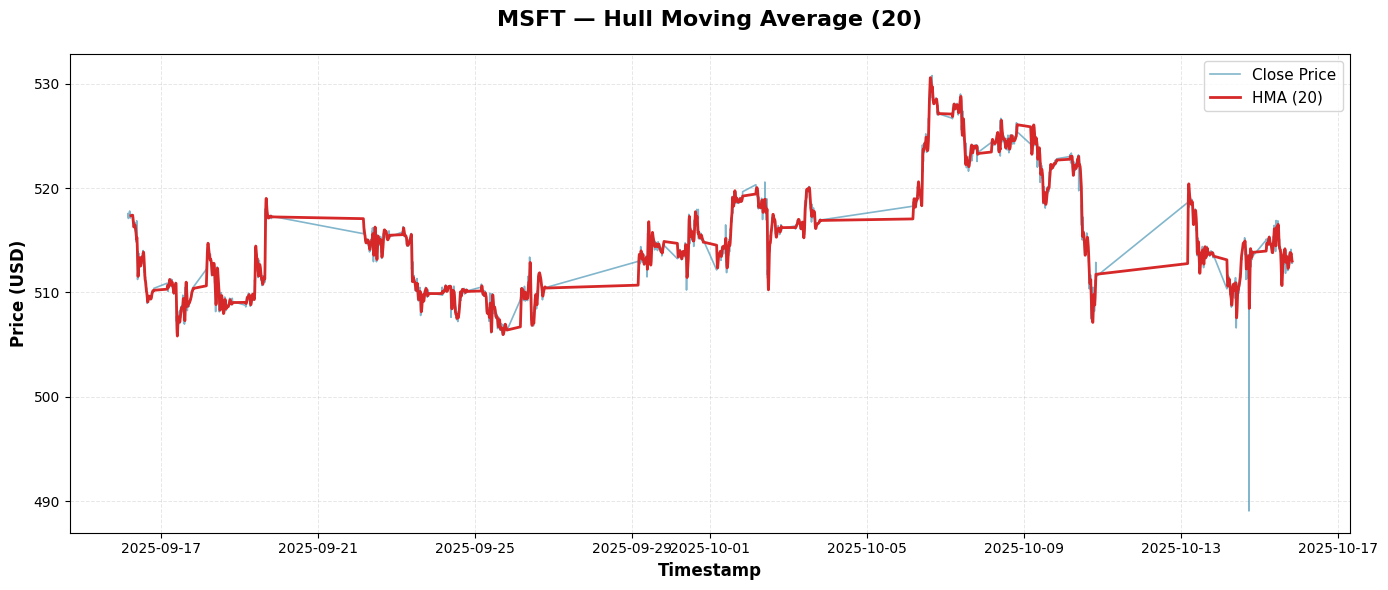

In [ ]:
#hull moving average

#weighted moving average - used for hull formula
def WMA(series, period):
    weights = np.arange(1, period + 1)
    return series.rolling(period).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)

#hull moving average
def HMA(series, period=20):
    half_length = int(period / 2)
    sqrt_length = int(np.sqrt(period))
    wma_half = WMA(series, half_length)
    wma_full = WMA(series, period)
    diff = 2 * wma_half - wma_full
    return WMA(diff, sqrt_length)

#plot with 20
df["HMA_20"] = HMA(df[price_col], 20)
plt.figure(figsize=(14, 6))
plt.plot(df.index, df[price_col], label="Close Price", alpha=0.6, color="#2E86AB", linewidth=1.2)
plt.plot(df.index, df["HMA_20"], label="HMA (20)", color="#D62828", linewidth=2)
plt.title(f"{symbol} — Hull Moving Average (20)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Timestamp", fontsize=12, fontweight='bold')
plt.ylabel("Price (USD)", fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

###11. Directional Moving Index / ADX
The DMI measured trend direction: whether it has upward or downward movement.

ADX measures the strength of the trend. If ADC is above 25 then the trend is strong, below 20 means the trend is weak.


=== Trend Strength Analysis — ADX / DMI ===


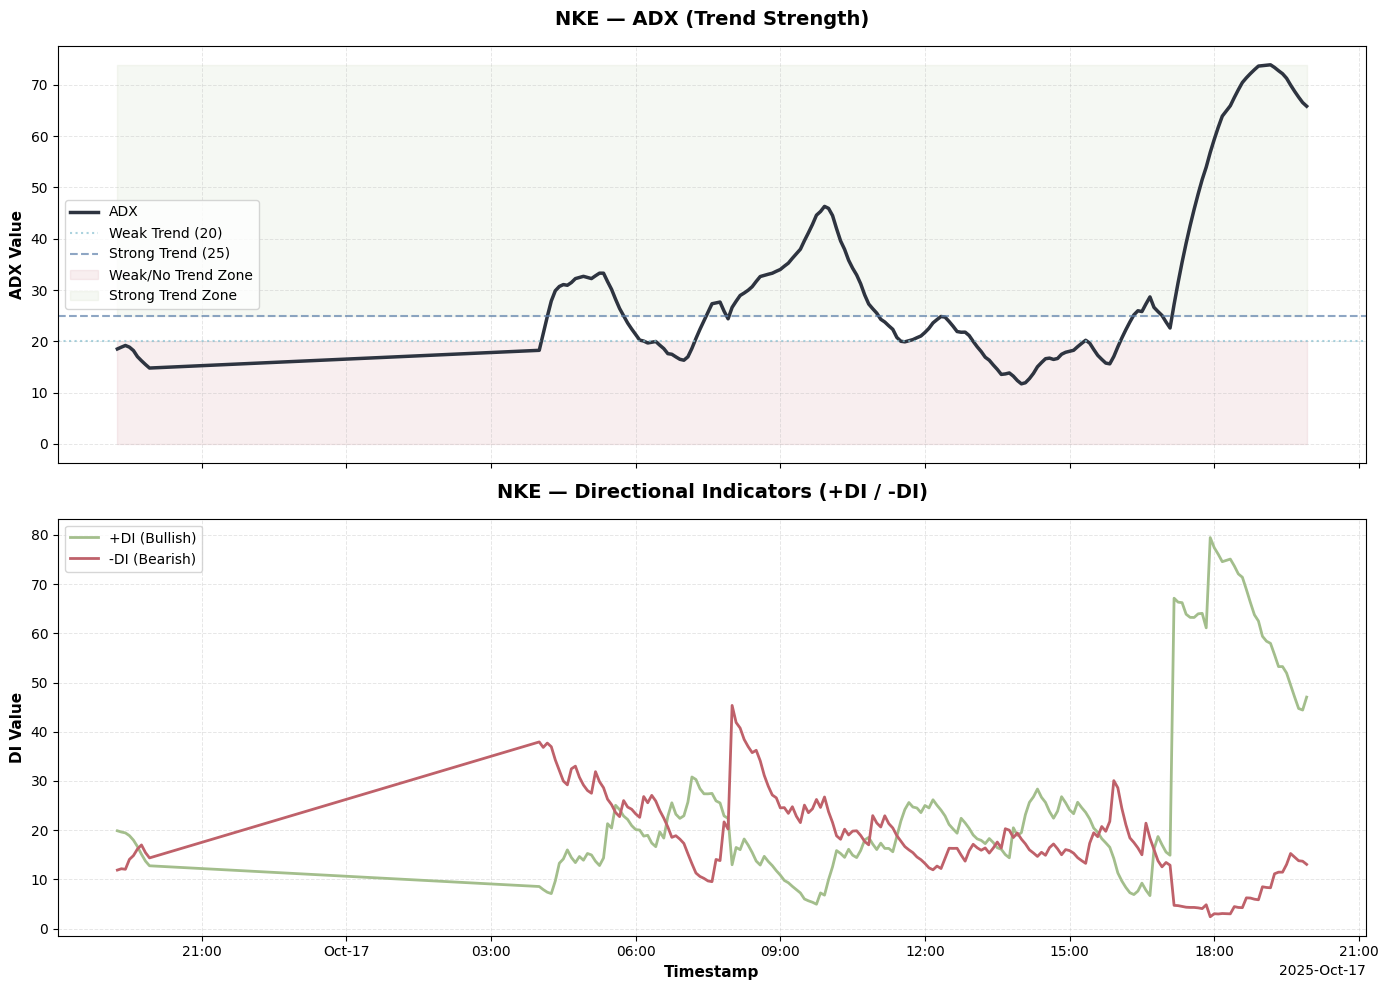


Interpretation:
• ADX > 25 → Strong trend; ADX < 20 → Weak/sideways trend
• +DI > -DI → Bullish trend; -DI > +DI → Bearish trend
• Crossovers of +DI and -DI indicate potential buy/sell signals


In [ ]:
#directional moving index (DMI) & ADX visualization

from ta.trend import ADXIndicator
import matplotlib.dates as mdates

print("\n=== Trend Strength Analysis — ADX / DMI ===")
#smaller interval range for graph clarity and readability
window = 14
N = 200

#DMI calculations
adx_indicator = ADXIndicator(
    high=df["high"],
    low=df["low"],
    close=df[price_col],
    window=window
)
df["ADX"] = adx_indicator.adx()
df["DMI_plus"] = adx_indicator.adx_pos()
df["DMI_minus"] = adx_indicator.adx_neg()

#only plot recent data
df_plot = df.iloc[-N:]
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#ADX — trend strength
axes[0].plot(df_plot.index, df_plot["ADX"], color="#2E3440", linewidth=2.5, label="ADX")
axes[0].axhline(20, color="#88C0D0", linestyle=":", linewidth=1.5, label="Weak Trend (20)", alpha=0.7)
axes[0].axhline(25, color="#5E81AC", linestyle="--", linewidth=1.5, label="Strong Trend (25)", alpha=0.7)
axes[0].fill_between(df_plot.index, 0, 20, alpha=0.1, color="#BF616A", label="Weak/No Trend Zone")
axes[0].fill_between(df_plot.index, 25, df_plot["ADX"].max(), alpha=0.1, color="#A3BE8C", label="Strong Trend Zone")
axes[0].set_title(f"{symbol} — ADX (Trend Strength)", fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel("ADX Value", fontsize=11, fontweight='bold')
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
axes[0].xaxis.set_major_locator(locator)
axes[0].xaxis.set_major_formatter(formatter)

#DI+ and DI− — trend direction
axes[1].plot(df_plot.index, df_plot["DMI_plus"], color="#A3BE8C", linewidth=2, label="+DI (Bullish)")
axes[1].plot(df_plot.index, df_plot["DMI_minus"], color="#BF616A", linewidth=2, label="-DI (Bearish)")
axes[1].set_title(f"{symbol} — Directional Indicators (+DI / -DI)", fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel("DI Value", fontsize=11, fontweight='bold')
axes[1].set_xlabel("Timestamp", fontsize=11, fontweight='bold')
axes[1].legend(fontsize=10, loc='best')
axes[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
axes[1].xaxis.set_major_locator(locator)
axes[1].xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

#results
print("\nInterpretation:")
print("• ADX > 25 → Strong trend; ADX < 20 → Weak/sideways trend")
print("• +DI > -DI → Bullish trend; -DI > +DI → Bearish trend")
print("• Crossovers of +DI and -DI indicate potential buy/sell signals")

### 12 Comparing the time series models to determine their accuracy by using the AIC, BIC, and RMSE metrics.

AIC and BIC - check for model complexity. The lower that is the better

RMSE - measures how close the model's predictions are to the actual values.





In [ ]:
#evaluating model accuracy

from sklearn.metrics import mean_squared_error

eval_rows = []

for name, model in results.items():
    aic = model.aic
    bic = model.bic

    # fitted values as a Pandas Series
    fitted = pd.Series(model.fittedvalues)

    # target (endogenous) series used by THIS model, with same index as fitted
    # (works across AR/MA on stationary_series and ARIMA on levels)
    try:
        endog = pd.Series(model.model.endog, index=fitted.index)
    except Exception:
        # Fallback: reindex your stationary series to fitted's index
        endog = pd.Series(stationary_series).reindex(fitted.index)

    # align & drop NaNs to ensure equal length
    aligned = pd.concat([endog.rename("y_true"), fitted.rename("y_hat")], axis=1).dropna()

    rmse = np.sqrt(mean_squared_error(aligned["y_true"], aligned["y_hat"]))
    n_used = len(aligned)

    eval_rows.append((name, aic, bic, rmse, n_used))

eval_df = pd.DataFrame(eval_rows, columns=["Model", "AIC", "BIC", "RMSE (in-sample)", "N used"])
print("=== Model Comparison (aligned) ===")
eval_df = eval_df.sort_values("AIC").reset_index(drop=True)
print(eval_df)


=== Model Comparison (aligned) ===
          Model           AIC           BIC  RMSE (in-sample)  N used
0         MA(1) -40445.612450 -40426.586789          0.001951    4196
1         AR(1) -40429.873184 -40410.847523          0.001955    4196
2  ARIMA(1,1,1)   6887.579738   6906.605398        280.307141    4196
